In [12]:
!pip install pgmpy > /dev/null 2>&1

from numpy.random import choice
from pgmpy.readwrite import BIFReader
from queue import Queue
from functools import reduce
from matplotlib import pyplot as plt
from tqdm import tqdm

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def generate_combinations(cur_combinations, cur_variables):
    """
    Recursively generate all possible combination for variable values.

    :param cur_combinations: [{variable1: value1, variable2: value2, ... }, { ... }, ... ]
    :param cur_variables: [variableX, variableY, ... ]
    :return: list of all possible combinations [{ ... }, { ... }, ... ]
    """
    if len(cur_variables) == 0:
        return cur_combinations
    cur_variable, rest_variables = cur_variables[0], cur_variables[1:]
    new_combinations = []
    # state - value of the variable
    for state in states[cur_variable]:
        for combination in cur_combinations:
            cur_combination = combination.copy()
            cur_combination[cur_variable] = state
            new_combinations.append(cur_combination)

    return generate_combinations(new_combinations, rest_variables)


def get_dict(cur_dict, node):
    """
    Auxiliary function which constructs a dictionary for getting a value from CPD.
    """
    keys = [node] + parents_dict[node]
    result = dict((k, cur_dict[k]) for k in keys)
    return result


def get_probability(cur_dict):
    """
    Calculates Joint Probability function for given variables, which are stored as dictionary.
    Calculation is performed by traversing model and calculating conditional probabilities.

    :param cur_dict: {variable1: value1, variable2: value2, ... , variableN: valueN}
    :return: P(variable1=value1, variable2=value2, ... , variableN: valueN)
    """
    q = Queue()
    visited_dict = {}
    for root_node in model.get_roots():
        q.put(root_node)
        visited_dict[root_node] = model.get_cpds(root_node).to_factor().get_value(**get_dict(cur_dict, root_node))
    while not q.empty():
        cur_node = q.get()
        for child in children_dict[cur_node]:
            if child not in visited_dict:
                visited_dict[child] = model.get_cpds(child).to_factor().get_value(**get_dict(cur_dict, child))
                q.put(child)
    return reduce(lambda x, y: x * y, visited_dict.values())

In [7]:
def query_brute_force(query_dict):
    """
    Calculates Joint Probability function of given events (some are missing) from query (direct method, brute force)

    :param query_dict: {variable1: value1, variable2: value2, ... }
    :return: P(variable1=value1, variable2=value2, ... )
    """
    all_combinations = [query_dict]
    missing_variables = list(set(variables) - set(query_dict.keys()))
    all_combinations = generate_combinations(all_combinations, missing_variables)
    probability = 0

    for combination in all_combinations:
        p = get_probability(combination)
        probability += p
    
    return probability


def query_sampling(query_dict, samples=10000):
    """
    Calculates Joint Probability function of given events (some are missing) from query (sampling method)

    :param query_dict: {variable1: value1, variable2: value2, ... }
    :param samples: number of samples
    :return: P(variable1=value1, variable2=value2, ... )
    """
    all_combinations = [{}]
    all_combinations = generate_combinations(all_combinations, variables)

    query_combinations = [query_dict]
    missing_variables = list(set(variables) - set(query_dict.keys()))
    query_combinations = generate_combinations(query_combinations, missing_variables)

    probabilities = []
    count_dict = {}
    for combination in all_combinations:
        count_dict[frozenset(combination.items())] = 0
        p = get_probability(combination)
        probabilities.append(p)

    for _ in range(samples):
        count_dict[frozenset(choice(all_combinations, p=probabilities).items())] += 1

    count_sum = 0
    for key in query_combinations:
        count_sum += count_dict[frozenset(key.items())]

    return count_sum / samples

In [8]:
def draw_plot(cur_dict, samples=1000):
    xs = []
    ys = []
    y = query_brute_force(cur_dict)

    for i in tqdm(range(1, samples, 10)):
        xs.append(i)
        ys.append(query_sampling(cur_dict, i))

    _, ax = plt.subplots()
    plt.plot(xs, ys, label='Sampling')
    plt.plot(xs, [y for _ in range(len(xs))], label='Brute force')
    ax.set_xlabel("Samples")
    ax.set_ylabel("Probability")
    plt.legend()
    plt.show()

In [9]:
data_path = "/content/drive/MyDrive/AdvancedML/cancer.bif"
reader = BIFReader(data_path)

# Get model information using Bayesian Interchange Format reader
model = reader.get_model()
variables = reader.get_variables()
edges = reader.get_edges()
states = reader.get_states()

# Construct parents and children dictionaries for vertexes from Bayesian Network graph
parents_dict, children_dict = {}, {}
for variable in variables:
    parents_dict[variable] = []
    children_dict[variable] = []

for [parent, child] in edges:
    parents_dict[child].append(parent)
    children_dict[parent].append(child)

print("Parents:")
print(parents_dict)
print("Children:")
print(children_dict)

for variable in variables:
    print(model.get_cpds(variable))

Parents:
{'Pollution': [], 'Smoker': [], 'Cancer': ['Pollution', 'Smoker'], 'Xray': ['Cancer'], 'Dyspnoea': ['Cancer']}
Children:
{'Pollution': ['Cancer'], 'Smoker': ['Cancer'], 'Cancer': ['Xray', 'Dyspnoea'], 'Xray': [], 'Dyspnoea': []}
+-----------------+-----+
| Pollution(low)  | 0.9 |
+-----------------+-----+
| Pollution(high) | 0.1 |
+-----------------+-----+
+---------------+-----+
| Smoker(True)  | 0.3 |
+---------------+-----+
| Smoker(False) | 0.7 |
+---------------+-----+
+---------------+----------------+-----+-----------------+
| Pollution     | Pollution(low) | ... | Pollution(high) |
+---------------+----------------+-----+-----------------+
| Smoker        | Smoker(True)   | ... | Smoker(False)   |
+---------------+----------------+-----+-----------------+
| Cancer(True)  | 0.03           | ... | 0.02            |
+---------------+----------------+-----+-----------------+
| Cancer(False) | 0.97           | ... | 0.98            |
+---------------+----------------+-----+

100%|██████████| 100/100 [00:02<00:00, 39.03it/s]


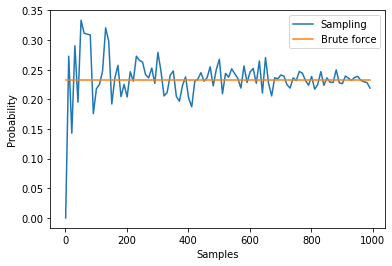

In [13]:
example_dict = {'Smoker': 'True',
                'Xray': 'negative'
                }

draw_plot(example_dict)

100%|██████████| 100/100 [00:02<00:00, 33.94it/s]


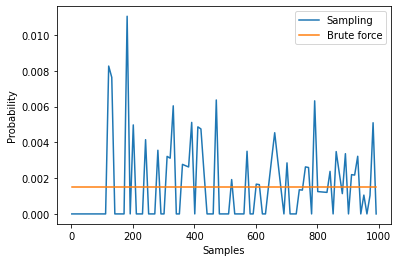

In [14]:
example_dict = {'Pollution': 'high',
                'Smoker': 'True',
                'Cancer': 'True'
                }
draw_plot(example_dict)

100%|██████████| 100/100 [00:02<00:00, 37.16it/s]


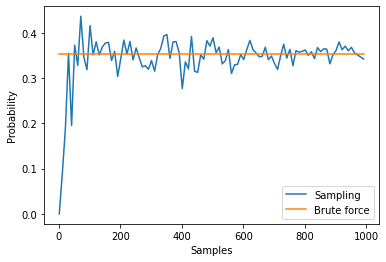

In [15]:
example_dict = {'Pollution': 'low',
                'Smoker': 'False',
                'Xray': 'negative',
                'Dyspnoea': 'False'
                }

draw_plot(example_dict, samples=1000)

100%|██████████| 1000/1000 [03:45<00:00,  4.44it/s]


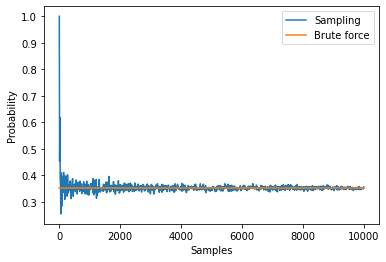

In [16]:
example_dict = {'Pollution': 'low',
                'Smoker': 'False',
                'Xray': 'negative',
                'Dyspnoea': 'False'
                }

draw_plot(example_dict, samples=10000)

100%|██████████| 100/100 [00:03<00:00, 28.94it/s]


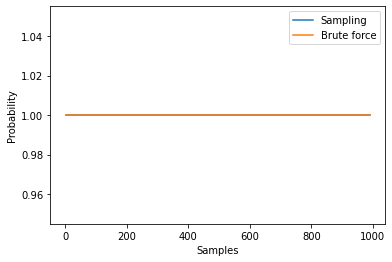

In [17]:
example_dict = {}

draw_plot(example_dict)